# Opinion Dynamics on a network

Replicates the 3 models presented [here](https://mariuzka.github.io/amp_page/06/amp06b.html), but interactions happen on a network.

In [28]:
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker

import random

from typing import List, Optional

import matplotlib.pyplot as plt

In [29]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        
        self.opinion: float = random.random()
        self.opinion_history: List[float] = []
        self.tolerance = self.model.p.tolerance
    
    
    def get_weight(self, contact: "Agent", mode: int = 1):
        """Calculates a weight which determines how the opinion of the contact will influence the focal agent."""
        
        # All contacts are weighted the same
        if mode == 1:
            return 1
        
        # bounded confidence: if the opinion of the contact is too far away from the focal agent's opinion, then the focal agent is not influenced by this opinion
        elif mode == 2:
            abs_opinion_diff = abs(contact.opinion - self.opinion)
        
            if abs_opinion_diff <= self.tolerance:
                return 1
            else:
                return 0
        
        # negative influence
        elif mode == 3:
            abs_opinion_diff = abs(contact.opinion - self.opinion)
            
            if abs_opinion_diff > 0.5:
                return -1 * (2 * abs_opinion_diff - 1)
           
            else:
                return 1 - 2 * abs_opinion_diff


    def change_opinion(self, mode: int = 1):
        """Simulates the influence of all contacts on the opinion of the focal agent."""

        # get all interaction weights as absolute values and calculate the sum
        sum_of_abs_weights = sum([abs(self.get_weight(contact=agent, mode=mode)) for agent in self.get_contacts()])

        # get all weighted differences in opinions between the focal agent and all his contacts
        sum_of_weighted_diffs = sum([(agent.opinion - self.opinion) * self.get_weight(contact=agent, mode=mode) for agent in self.get_contacts()])

        if sum_of_abs_weights != 0 and sum_of_weighted_diffs != 0:
            # calculate opinion change as a weighted average of opinion differences
            opinion_change = sum_of_weighted_diffs / sum_of_abs_weights
        
            # change opinion
            self.opinion += opinion_change

        # keep the opinion between 0 and 1
        if self.opinion < 0:
            self.opinion = 0
        elif self.opinion > 1:
            self.opinion = 1

    
    def record_opinion(self):
        """Stores the current opinion value in a list to analyze it after the simulation."""
        self.opinion_history.append(self.opinion)

In [30]:
class Home(popy.Location):
    def groupby(self, agent):
        return agent.hid


class Work(popy.Location):
    def setup(self):
        self.size = 10
    
    def can_affiliate(self, agent):
        return agent.work_hours_day > 0
    

class School(popy.Location):
    def setup(self):
        self.size = 25
    
    def can_affiliate(self, agent) -> bool:
        return 6 <= agent.age <= 18


class All(popy.Location):
    pass

In [31]:
class Model(popy.Model):
    
    def setup(self):
        # micro-level data
        df_soep = soep_faker.soep(size=self.p.n_agents)
        
        # PopMaker: creates the population
        self.pop_maker = PopMaker(model=self)
        
        # create the population of agents using PopMaker
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)

        # create the corresponding locations using PopMaker
        self.locations = self.pop_maker.create_locations(
            agents=self.agents, 
                location_classes=[
                Home, 
                Work, 
                School,
                #All,
            ]
        )


    def step(self):
        # select one random agent
        focal_agent = self.agents.random(n=1)

        # execute agent behavior
        focal_agent.change_opinion(mode=self.p.opinion_weight_mode)
        

    def update(self):
        self.agents.record_opinion()

Completed: 5000 steps
Run time: 0:00:01.096992
Simulation finished


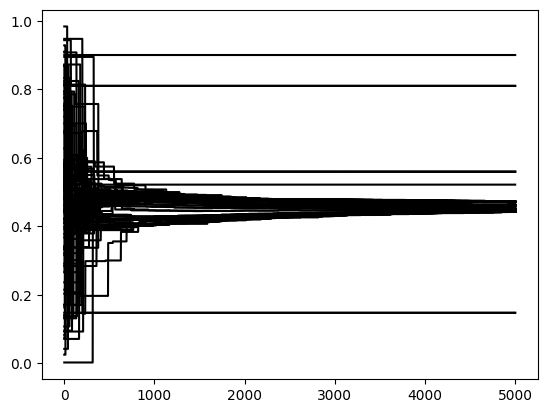

In [32]:
parameters = {
    "steps": 5000,
    "n_agents": 100,
    "opinion_weight_mode": 1,
    "tolerance": 0.3,
}
model = Model(parameters=parameters)

results = model.run()

for agent in model.agents:
    plt.plot(agent.opinion_history, color="black")

Completed: 8000 steps
Run time: 0:00:01.606122
Simulation finished


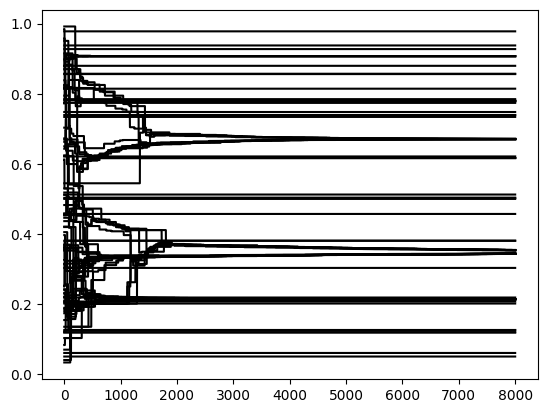

In [33]:
parameters = {
    "steps": 8000,
    "n_agents": 100,
    "opinion_weight_mode": 2,
    "tolerance": 0.2,
}
model = Model(parameters=parameters)

results = model.run()

for agent in model.agents:
    plt.plot(agent.opinion_history, color="black")

Completed: 3000 steps
Run time: 0:00:00.678167
Simulation finished


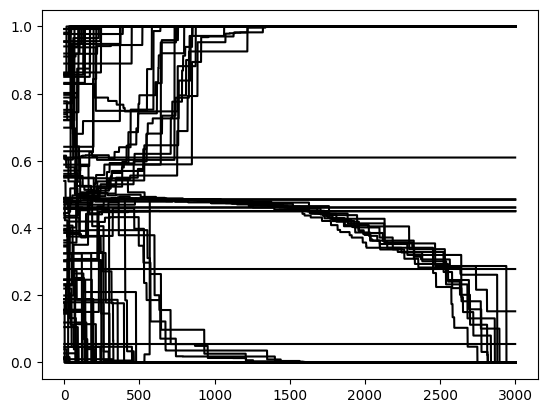

In [34]:
parameters = {
    "steps": 3000,
    "n_agents": 100,
    "opinion_weight_mode": 3,
    "tolerance": 0.3,
}
model = Model(parameters=parameters)

results = model.run()

for agent in model.agents:
    plt.plot(agent.opinion_history, color="black")